<font color='green' style='font-size:32px'><b>Walking You Through My Neural Style Transfer Script</b></font>
***
The VGG-16 network was loaded with pretrained ImageNet weights, and only the convolutional layers up to the final pooling layer were used. For the style loss, I extracted features from five different convolutional layers: conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1. To calculate the content loss I used a single deep convolutional layer, selecting conv5_3 (layer 28), which appears immediately after the final pooling layer. By only focusing on a signular deep convultion layer for the content loss, the model aims to retain information about higher-level details such as general shape and positioning of the content image. By comparison, the style loss pulls from 5 convolution layers and so lower-level details like edges and textures will be retained. This makes it possible to apply the stylistic details from the style image and apply it to the framework of the content image. 

In terms of hyperparameters, I chose a content weight of 1e3 and a style weight of 1e6, resulting in a 1000:1 ratio. This high style weight ensures that the generated image strongly reflects the texture and visual "feel" of the style image, while still preserving the structure and layout from the content image. If the style weight were significantly lower, the generated image would retain too much of the content image and not absorb enough of the artistic style, making the transformation less noticeable. On the other hand, if the style weight were even higher, the result might become overly abstract or distorted and lose the structure of the content image entirely. 

The content loss and style loss are computed using mean squared error (MSE), and the optimizer used is L-BFGS, which tends to work well for neural style transfer due to its ability to fine-tune a high-dimensional input image.

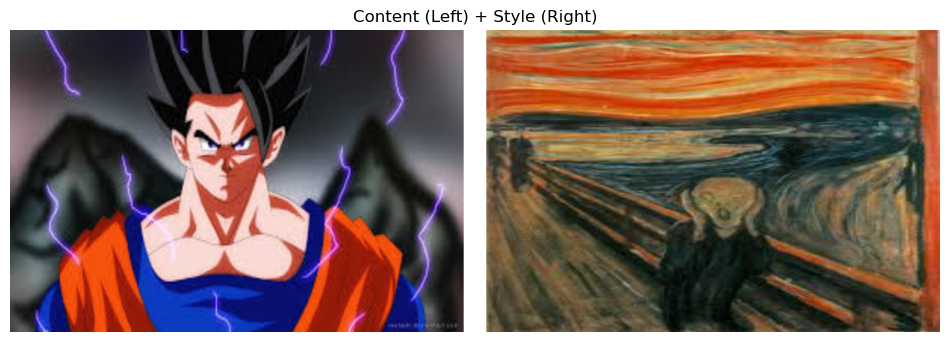

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\alexm/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:16<00:00, 32.8MB/s] 


Optimizing...
Epoch [30/300]
Style Loss: 3813541.0000 | Content Loss: 0.1396
Epoch [60/300]
Style Loss: 547657.3750 | Content Loss: 0.1453
Epoch [90/300]
Style Loss: 284617.0625 | Content Loss: 0.1458
Epoch [120/300]
Style Loss: 182223.7656 | Content Loss: 0.1446
Epoch [150/300]
Style Loss: 122289.6094 | Content Loss: 0.1451
Epoch [180/300]
Style Loss: 89057.7812 | Content Loss: 0.1444
Epoch [210/300]
Style Loss: 68159.0156 | Content Loss: 0.1440
Epoch [240/300]
Style Loss: 54232.6406 | Content Loss: 0.1434
Epoch [270/300]
Style Loss: 44812.1250 | Content Loss: 0.1428
Epoch [300/300]
Style Loss: 37628.4766 | Content Loss: 0.1425


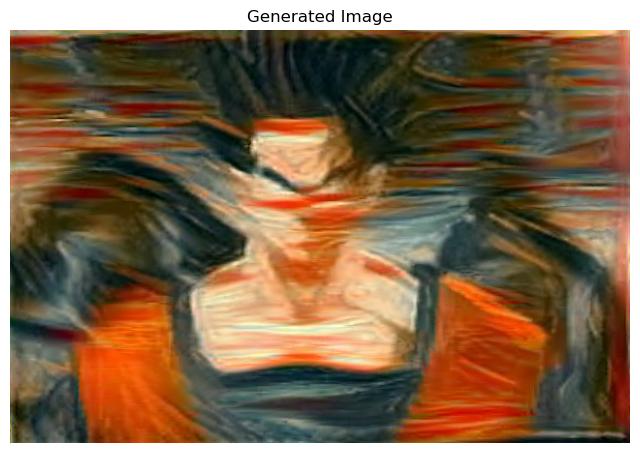

In [1]:
#---------- Imports ----------#
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os

#---------- Device and Transform Setup ----------#
device = 'cuda' if torch.cuda.is_available() else 'cpu'
imsize = (400, 600)  # height x width
transform = transforms.Compose([
    transforms.Resize(size=imsize),
    transforms.ToTensor()
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

#---------- Load Images ----------#
content_path = 'Neural Transfer Images/Content Image.jpg'
style_path = 'Neural Transfer Images/Style Image 2.jpg'

content_img = load_image(content_path)
style_img = load_image(style_path)

#---------- Show Input Images ----------#
content_np = content_img.squeeze().permute(1, 2, 0).cpu().numpy()
style_np = style_img.squeeze().permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 6))
plt.imshow(np.concatenate((content_np,
                           np.ones((imsize[0], int(0.05*imsize[1]), 3)),  # spacer
                           style_np), axis=1))
plt.title("Content (Left) + Style (Right)")
plt.axis('off')
plt.show()

#---------- Define Style Transfer Model (VGG-16) ----------#
class VGG16Features(nn.Module):
    def __init__(self):
        super(VGG16Features, self).__init__()
        vgg = models.vgg16(weights='DEFAULT').features.to(device).eval()

        self.model = vgg
        self.style_layers = [0, 5, 10, 17, 24]   # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.content_layer = 28                # conv5_3 (right after last pool)

    def forward(self, x):
        style_feats = []
        content_feat = None

        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in self.style_layers:
                style_feats.append(x)
            if i == self.content_layer:
                content_feat = x

        return style_feats, content_feat

#---------- Initialize Model ----------#
model = VGG16Features().to(device).eval()
for param in model.parameters():
    param.requires_grad = False

#---------- Hyperparameters ----------#
content_weight = 1e3
style_weight = 1e6
EPOCHS = 300
n_saves = 10
every_save = EPOCHS // n_saves

#---------- Setup Generated Image & Optimizer ----------#
generated_img = content_img.clone().requires_grad_(True)
optimizer = optim.LBFGS([generated_img])
mse = nn.MSELoss()
img_count = [1]
run = [0]

#---------- Create Save Directory ----------#
os.makedirs('./generated-process', exist_ok=True)

#---------- Optimization Loop ----------#
print("Optimizing...")

while run[0] <= EPOCHS:
    def closure():
        with torch.no_grad():
            generated_img.clamp_(0, 1)

        optimizer.zero_grad()

        gen_style_feats, gen_content_feat = model(generated_img)
        true_style_feats, true_content_feat = model(style_img)
        _, content_feat = model(content_img)

        # Content loss (only one layer)
        content_loss = mse(gen_content_feat, content_feat)

        # Style loss (multiple layers using Gram matrices)
        style_loss = 0.0
        for gen_feat, style_feat in zip(gen_style_feats, true_style_feats):
            _, c, h, w = gen_feat.shape

            G = gen_feat.view(c, h * w)
            A = style_feat.view(c, h * w)

            G_gram = torch.matmul(G, G.t())
            A_gram = torch.matmul(A, A.t())

            style_loss += mse(G_gram, A_gram)

        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()

        run[0] += 1
        if run[0] % every_save == 0:
            print(f"Epoch [{run[0]}/{EPOCHS}]")
            print(f"Style Loss: {style_loss.item():.4f} | Content Loss: {content_loss.item():.4f}")
            save_image(generated_img, f"./generated-process/generated-{img_count[0]:02d}.jpg")
            img_count[0] += 1

        return total_loss

    optimizer.step(closure)

#---------- Final Clamp and Show Result ----------#
with torch.no_grad():
    generated_img.clamp_(0, 1)

final_img = generated_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(8, 6))
plt.imshow(final_img)
plt.title("Generated Image")
plt.axis('off')
plt.show()

#---------- Save Final Image ----------#
save_image(generated_img, "./generated-final.jpg")
